In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import requests
import csv
import time
import re

page = requests.get("https://www.sarouty.ma/acheter/proprietes-a-vendre.html")
# Configuration de Selenium
options = webdriver.ChromeOptions()
options.add_argument("--headless=new") 
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument(
    'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
    'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'
)

driver = webdriver.Chrome(options=options)

# Création du fichier CSV
with open("scraped_sarouty.csv", "w", newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["prix", "ville", "nombre de chambres", "surface", "type", "date de publication"])

    # Scraping des pages
    for page in range(1,500):
        print(f"Scraping page {page}...")
        url = f"https://www.sarouty.ma/acheter/proprietes-a-vendre.html?p={page}"
        driver.get(url)
        time.sleep(4)

        soup = BeautifulSoup(driver.page_source, "html.parser")
        annonces = soup.find_all("div", class_="card-list__item")
        print('Nombre d\'annonces trouvées:', len(annonces))
        for annonce in annonces:
            prix = annonce.find("p", class_="card-intro__price")
            prix = prix.text.strip() if prix else "null"

            type_bien = annonce.find("p", class_="card-intro__type")
            type_bien = type_bien.text.strip() if type_bien else "null"

            ville = annonce.find("span", class_="card-specifications__location-text")
            ville = ville.text.strip() if ville else "null"

            date = annonce.find("p", class_="card-footer__publish-date")
            date = date.text.strip() if date else "null"

            specs = annonce.find_all("p", class_="card-specifications__item")
            chambre = surface = "null"
            for spec in specs:
                txt = spec.text.lower()
                if "bedroom" in txt or "chambre" in txt:
                    chambre = spec.text.strip()
                if "m²" in txt or "m2" in txt:
                    surface = spec.text.strip()
              
            #print(f"{prix} | {ville} | {chambre} | {surface} | {type_bien} | {date}")
            writer.writerow([prix, ville, chambre, surface, type_bien, date])

driver.quit()

Scraping page 1...
Nombre d'annonces trouvées: 31
Scraping page 2...
Nombre d'annonces trouvées: 31
Scraping page 3...
Nombre d'annonces trouvées: 31
Scraping page 4...
Nombre d'annonces trouvées: 30
Scraping page 5...
Nombre d'annonces trouvées: 31
Scraping page 6...
Nombre d'annonces trouvées: 31
Scraping page 7...
Nombre d'annonces trouvées: 31
Scraping page 8...
Nombre d'annonces trouvées: 31
Scraping page 9...
Nombre d'annonces trouvées: 31
Scraping page 10...
Nombre d'annonces trouvées: 31
Scraping page 11...
Nombre d'annonces trouvées: 31
Scraping page 12...
Nombre d'annonces trouvées: 31
Scraping page 13...
Nombre d'annonces trouvées: 30
Scraping page 14...
Nombre d'annonces trouvées: 31
Scraping page 15...
Nombre d'annonces trouvées: 31
Scraping page 16...
Nombre d'annonces trouvées: 31
Scraping page 17...
Nombre d'annonces trouvées: 31
Scraping page 18...
Nombre d'annonces trouvées: 31
Scraping page 19...
Nombre d'annonces trouvées: 30
Scraping page 20...
Nombre d'annonces tr

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta
# Chargement du fichier CSV
df = pd.read_csv('scraped_sarouty.csv')

# SUPPRIMER LES DOUBLONS
#df = df.drop_duplicates()

# SUPPRIMER LES LIGNES AVEC DES VALEURS MANQUANTES IMPORTANTES
df = df.dropna(subset=['prix', 'ville', 'nombre de chambres', 'surface', 'type'])

# Nettoyage colonne 'prix' : suppression de 'MAD', espaces, etc., conversion en float
def clean_price(price):
    if pd.isnull(price):
        return np.nan
    cleaned = re.sub(r'\D', '', str(price))
    return float(cleaned) if cleaned else np.nan

df['prix'] = df['prix'].apply(clean_price)

# Nettoyage colonne 'surface' : suppression de 'm²'=
def clean_surface(surf):
    if pd.isnull(surf):
        return np.nan
    cleaned = re.sub(r'[^\d]', '', str(surf))
    return float(cleaned) if cleaned else np.nan

df['surface'] = df['surface'].apply(clean_surface)

def clean_chambre(chambre):
    if pd.isnull(chambre) or str(chambre).strip().lower() in ['n/a', 'none', 'nan']:
        return np.nan
    cleaned = re.findall(r'\d+', str(chambre))
    return float(cleaned[0]) if cleaned else np.nan

df['nombre de chambres'] = df['nombre de chambres'].apply(clean_chambre)


# On enlève les lignes avec surface ou prix au-dessus ou en-dessous de seuils arbitraires
df = df[(df['prix'] > 500000) & (df['prix'] < 15000000)]
df = df[(df['surface'] > 20) & (df['surface'] < 1000)]
df = df[(df['nombre de chambres'] >= 1) & (df['nombre de chambres'] <= 8)]


# ENCODAGE DES VARIABLES CATÉGORIELLES (one-hot ou label encoding)

le_type = LabelEncoder()
df['type_enc'] = le_type.fit_transform(df['type'].astype(str))

le_ville = LabelEncoder()
df['ville_enc'] = le_ville.fit_transform(df['ville'].astype(str))
# --- Étape 9 : Transformer la "date de publication" en date approximative ---
def convert_to_date(text):
    today = datetime.now()
    # Convertir en string si ce n’est pas déjà une string
    if not isinstance(text, str):
        text = str(text)
    if "more than 6 months ago" in text:
        return today - timedelta(days=7 * 30)
    elif "il y a 5 mois" in text:
        return today - timedelta(days=5 * 30)
    elif "il y a 4 mois" in text:
        return today - timedelta(days=4 * 30)
    elif "il y a 2 mois" in text:
        return today - timedelta(days=2 * 30)
    elif "il y a un mois" in text:
        return today - timedelta(days=30)
    else:
        return today


# Appliquer la fonction
#df['date de publication'] = df['date de publication'].astype(str)
df['date de publication'] = df['date de publication'].apply(convert_to_date)

# RÉINITIALISATION DE L'INDEX
df = df.reset_index(drop=True)

# AFFICHER LE RÉSULTAT NETTOYÉ
print(df.head())
#print(df['date de publication'].apply(type).value_counts())
# Sauvegarder le dataframe nettoyé
df.to_csv('scraped_sarouty_cleaned.csv', index=False)

        prix                           ville  nombre de chambres  surface  \
0  9500000.0              Chrifia, Marrakech                 5.0    854.0   
1  8900000.0  Route de Tahanaoute, Marrakech                 4.0    460.0   
2  8300000.0                Agdal, Marrakech                 5.0    450.0   
3  3200000.0         Dar Bouazza, Casablanca                 3.0    274.0   
4  2900000.0                Plaza, Marrakech                 2.0    144.0   

          type        date de publication  type_enc  ville_enc  
0        Villa 2024-12-21 22:02:51.762749         1          4  
1        Villa 2025-05-20 22:02:51.762757         1         10  
2        Villa 2025-06-19 22:02:51.762759         1          0  
3        Villa 2024-12-21 22:02:51.762760         1          5  
4  Appartement 2024-12-21 22:02:51.762762         0          7  


In [43]:
df['ville'] = df['ville'].astype(str)
df = pd.get_dummies(df, columns=['ville'], drop_first=True)  # One-hot encoding

df['surface_cat'] = pd.cut(df['surface'], bins=[0, 50, 100, 150, 200, np.inf],
                           labels=['Très petit', 'Petit', 'Moyen', 'Grand', 'Très grand'])

df['prix_par_m2'] = df['prix'] / df['surface']

densites = {
    'Casablanca': 12_000, 
    'Rabat': 8_000,
    'Marrakech': 6_000,
    'Fès': 7_000,
    'Agadir': 5_000
}

df['densite_ville'] = df['ville_enc'].map(densites)

df['densite_annonces'] = df.groupby('ville_enc')['ville_enc'].transform('count')


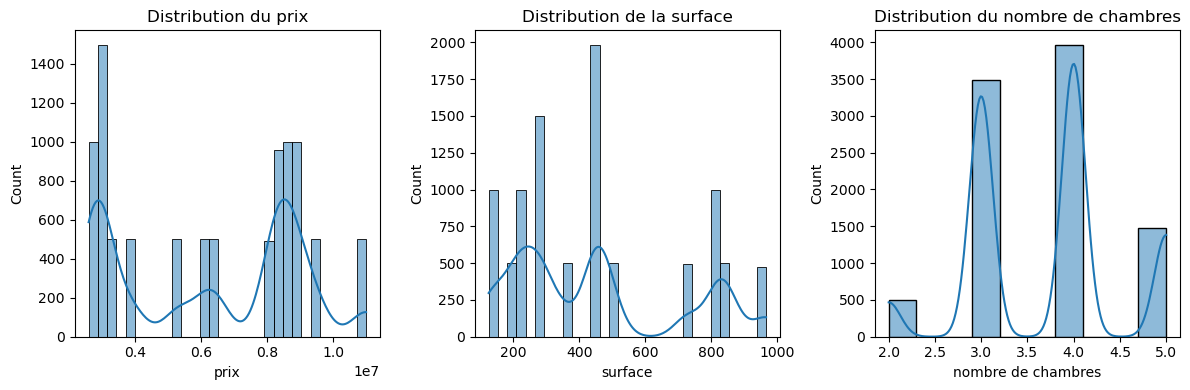

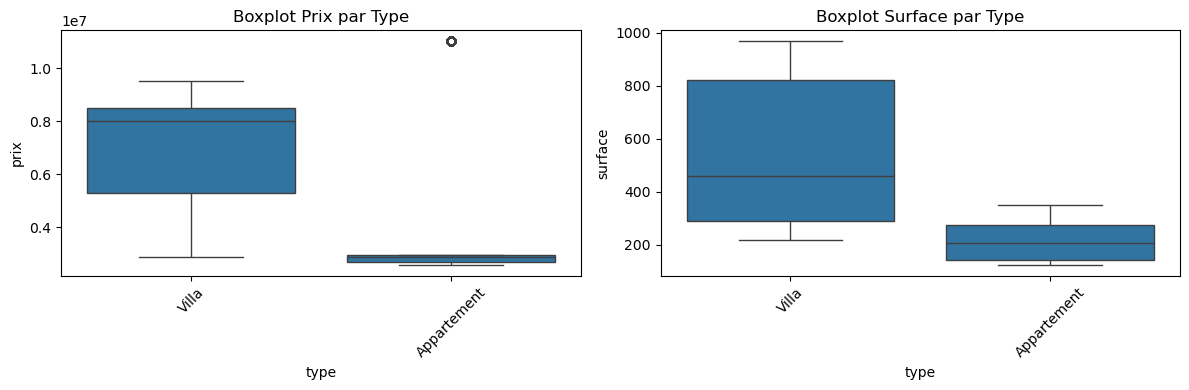

In [45]:
##################### Visualisation des distributions #####################"
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder

# Chargement du fichier CSV
df = pd.read_csv('scraped_sarouty_cleaned.csv')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['prix'], bins=30, kde=True)
plt.title('Distribution du prix')
plt.subplot(1, 3, 2)
sns.histplot(df['surface'], bins=30, kde=True)
plt.title('Distribution de la surface')
plt.subplot(1, 3, 3)
sns.histplot(df['nombre de chambres'], bins=10, kde=True)
plt.title('Distribution du nombre de chambres')
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='type', y='prix', data=df)
plt.title('Boxplot Prix par Type')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.boxplot(x='type', y='surface', data=df)
plt.title('Boxplot Surface par Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
##################### Statistiques descriptives #####################"

print(df.describe())
print(df[['prix', 'surface', 'nombre de chambres']].describe())
print(df['ville'].value_counts())
print(df['type'].value_counts())


               prix  nombre de chambres      surface     type_enc    ville_enc
count  9.433000e+03         9433.000000  9433.000000  9433.000000  9433.000000
mean   6.263299e+06            3.680483   451.431570     0.735503     5.909891
std    2.761828e+06            0.797777   255.716996     0.441088     3.338155
min    2.600000e+06            2.000000   125.000000     0.000000     0.000000
25%    2.980000e+06            3.000000   220.000000     0.000000     4.000000
50%    6.500000e+06            4.000000   440.000000     1.000000     5.000000
75%    8.500000e+06            4.000000   730.000000     1.000000     9.000000
max    1.100000e+07            5.000000   967.000000     1.000000    11.000000
               prix      surface  nombre de chambres
count  9.433000e+03  9433.000000         9433.000000
mean   6.263299e+06   451.431570            3.680483
std    2.761828e+06   255.716996            0.797777
min    2.600000e+06   125.000000            2.000000
25%    2.980000e+06   22

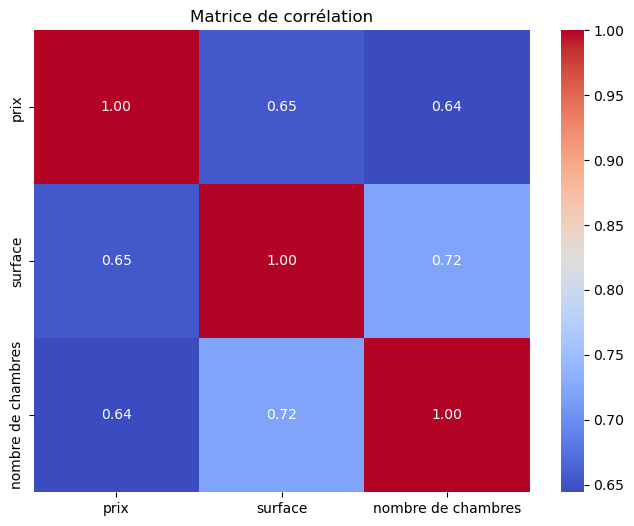

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des variables numériques
corr_matrix = df[['prix', 'surface', 'nombre de chambres']].corr()

# Affichage de la heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()


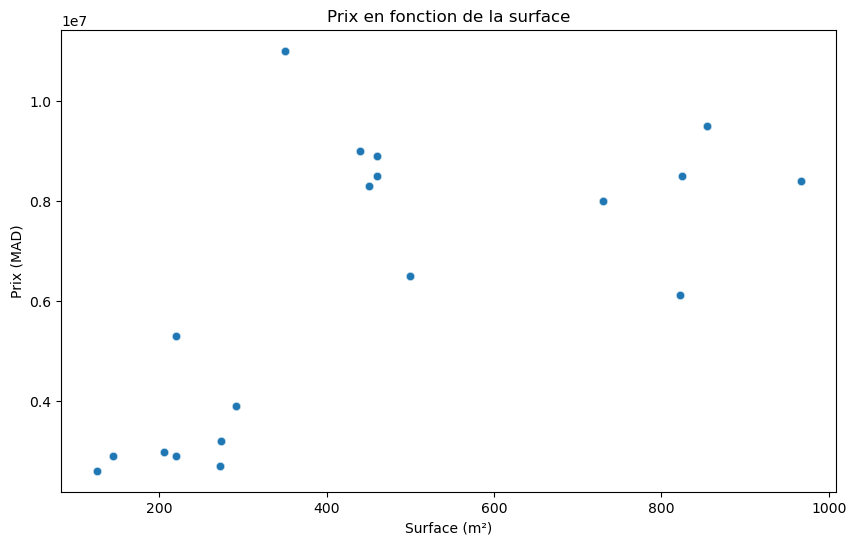

In [12]:
# Prix vs Surface
plt.figure(figsize=(10,6))
sns.scatterplot(x='surface', y='prix', data=df, alpha=0.6)
plt.title("Prix en fonction de la surface")
plt.xlabel("Surface (m²)")
plt.ylabel("Prix (MAD)")
plt.show()


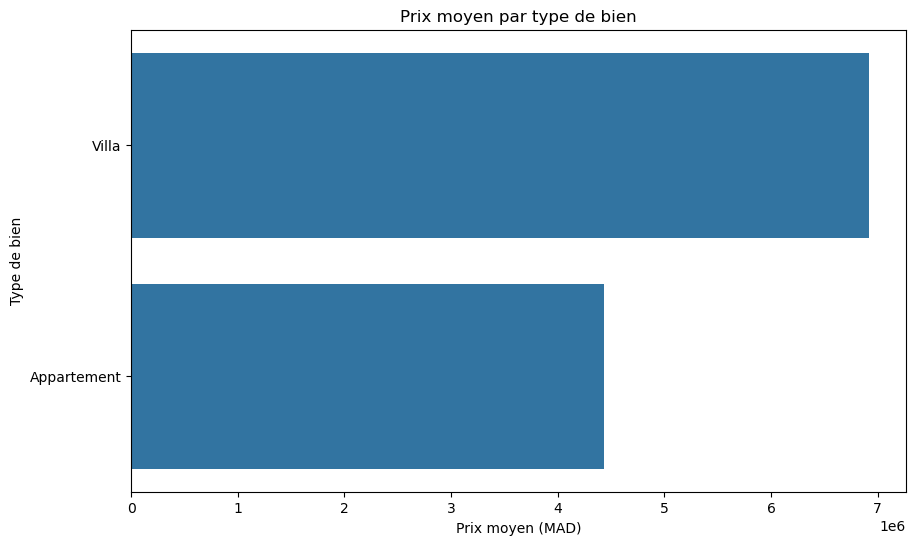

In [14]:
# Prix moyen par type de bien (colonne correcte = 'type')
prix_moyen_par_type = df.groupby('type')['prix'].mean().sort_values(ascending=False)

# Affichage du barplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x=prix_moyen_par_type.values, y=prix_moyen_par_type.index)
plt.title("Prix moyen par type de bien")
plt.xlabel("Prix moyen (MAD)")
plt.ylabel("Type de bien")
plt.show()


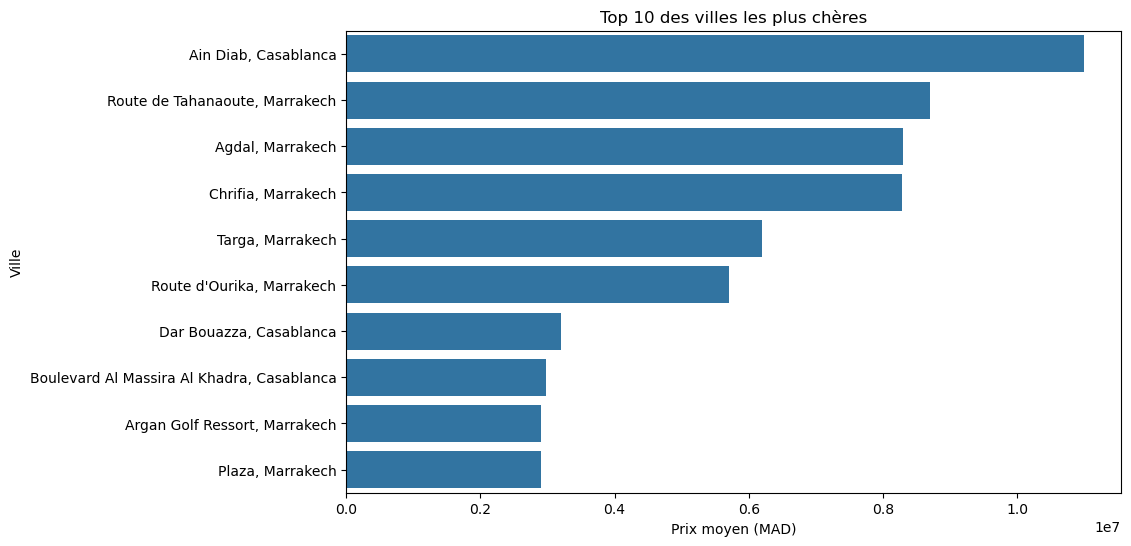

In [16]:
# Prix moyen par ville (Top 10)
prix_moyen_par_ville = df.groupby('ville')['prix'].mean().sort_values(ascending=False).head(10)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x=prix_moyen_par_ville.values, y=prix_moyen_par_ville.index)
plt.title("Top 10 des villes les plus chères")
plt.xlabel("Prix moyen (MAD)")
plt.ylabel("Ville")
plt.show()


                Modèle          RMSE           MAE        R2       CV_RMSE
4              XGBoost  6.671964e+04  2.225804e+04  0.999402  6.505359e+04
3        Random Forest  6.671969e+04  2.225755e+04  0.999402  6.505349e+04
0  Régression Linéaire  1.943095e+06  1.546179e+06  0.492458  1.936844e+06
2                Lasso  1.943095e+06  1.546179e+06  0.492458  1.936844e+06
1                Ridge  1.943095e+06  1.546134e+06  0.492458  1.936844e+06


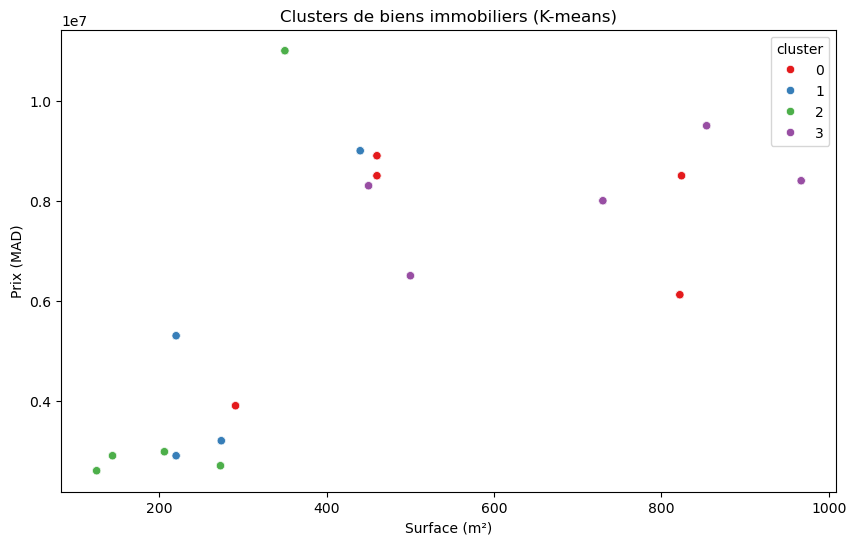

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données (après nettoyage)
df = pd.read_csv('scraped_sarouty_cleaned.csv')

# Définition des features et target
X = df[['surface', 'nombre de chambres', 'type_enc', 'ville_enc']]
y = df['prix']

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialisation des modèles
models = {
    'Régression Linéaire': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Entraînement, prédiction et évaluation
results = []
for name, model in models.items():
    # Entraînement
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calcul des métriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation RMSE
    cv_rmse_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -np.mean(cv_rmse_scores)  # La moyenne des scores de validation croisée (en RMSE)
    
    # Ajout des résultats
    results.append({
        'Modèle': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_RMSE': cv_rmse
    })

# Affichage des résultats
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)

# Clustering K-means (sur données normalisées)
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualisation des clusters (prix vs surface)
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='surface', y='prix', hue='cluster', palette='Set1')
plt.title("Clusters de biens immobiliers (K-means)")
plt.xlabel("Surface (m²)")
plt.ylabel("Prix (MAD)")
plt.show()

In [33]:
import joblib

# Récupérer le modèle XGBoost entraîné depuis le dictionnaire
XGBoost = models['XGBoost']

# Sauvegarder le modèle dans un fichier
joblib.dump(XGBoost, 'XGBoost.joblib')

print("✅ Modèle XGBoost sauvegardé avec succès.")


✅ Modèle XGBoost sauvegardé avec succès.


                Modèle          RMSE           MAE        R2       CV_RMSE
4              XGBoost  6.671964e+04  2.225804e+04  0.999402  6.505359e+04
3        Random Forest  6.671969e+04  2.225755e+04  0.999402  6.505349e+04
0  Régression Linéaire  1.943095e+06  1.546179e+06  0.492458  1.936844e+06
2                Lasso  1.943095e+06  1.546179e+06  0.492458  1.936844e+06
1                Ridge  1.943095e+06  1.546134e+06  0.492458  1.936844e+06


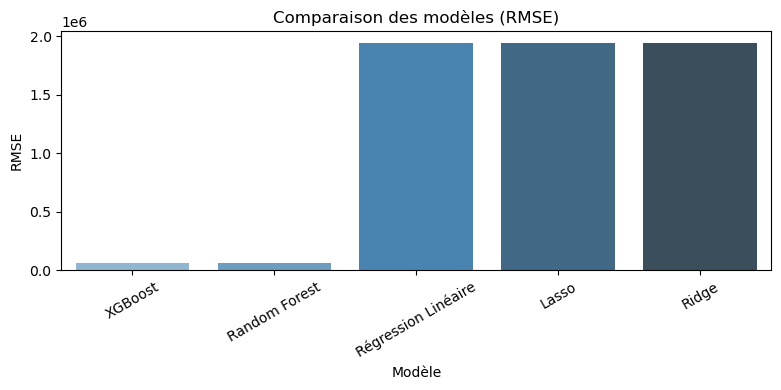

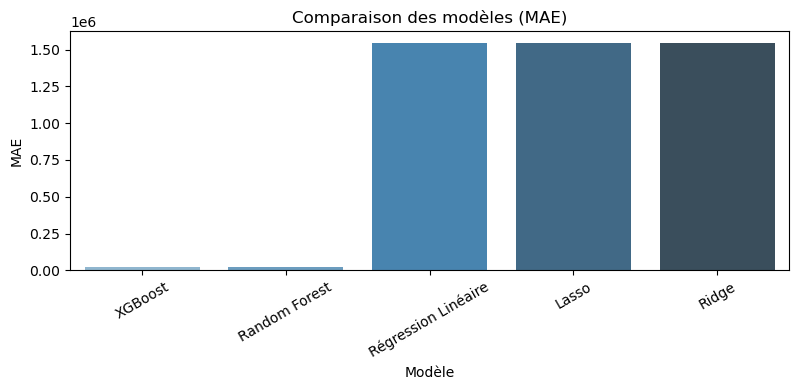

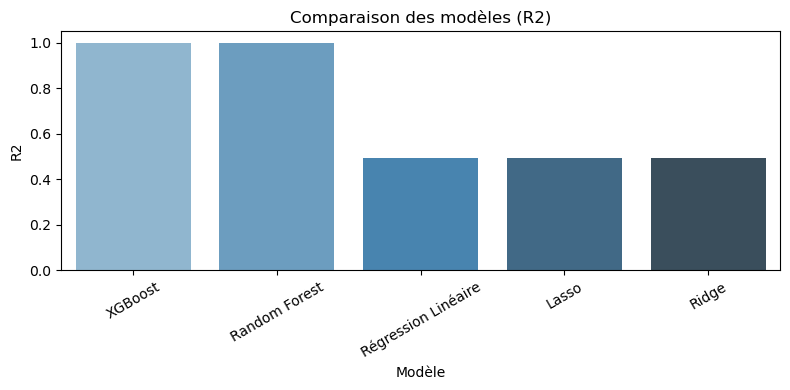

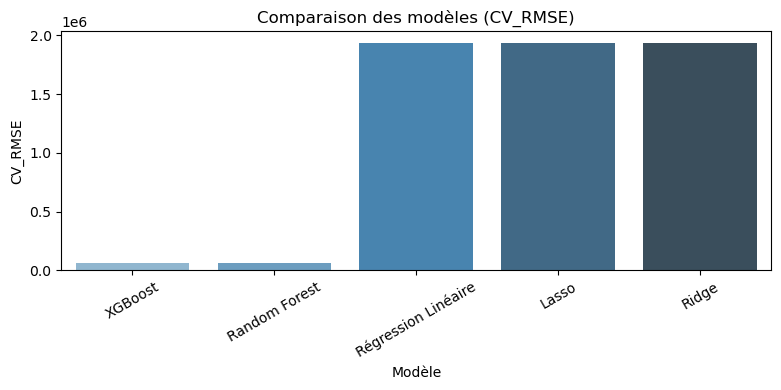

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

print(results_df)

metrics = ['RMSE', 'MAE', 'R2', 'CV_RMSE']
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.barplot(
        x='Modèle',
        y=metric,
        data=results_df,
        palette="Blues_d",
        hue='Modèle',
        legend=False
    )
    plt.title(f'Comparaison des modèles ({metric})')
    plt.ylabel(metric)
    plt.xlabel('Modèle')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


              Feature  Importance
0             surface    0.851363
1  nombre de chambres    0.082449
3           ville_enc    0.066188
2            type_enc    0.000000


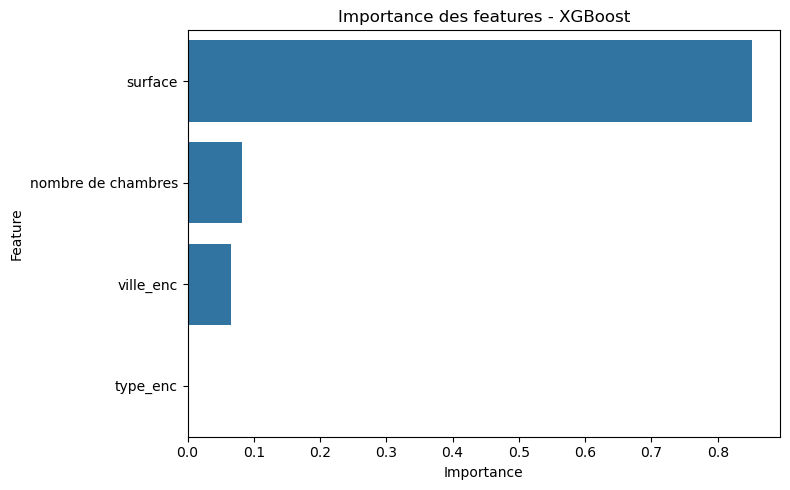

In [37]:
# Récupérer les importances des features depuis le modèle XGBoost
importances = models['XGBoost'].feature_importances_
features = X.columns  # les noms des colonnes (features)

# Créer un DataFrame pour mieux visualiser
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

# Afficher le tableau des importances
print(feat_imp)

# Visualisation avec seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Importance des features - XGBoost")
plt.tight_layout()
plt.show()

              Feature  Importance
0             surface    0.908934
1  nombre de chambres    0.038115
3           ville_enc    0.035071
2            type_enc    0.017879


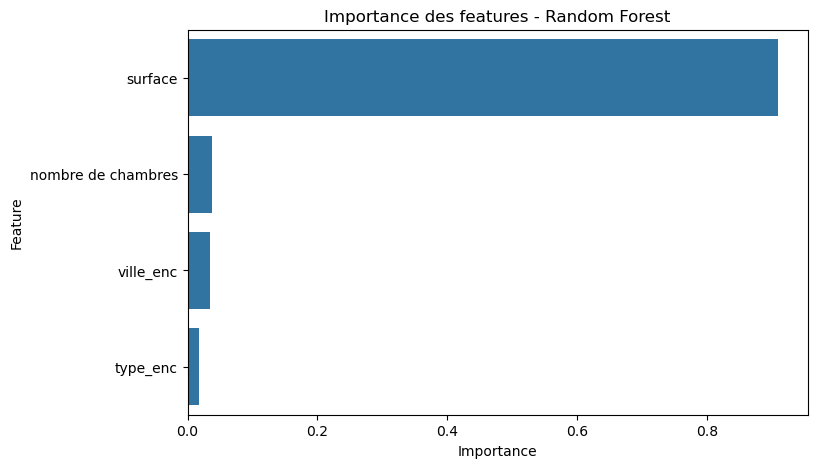

In [39]:
importances = models['Random Forest'].feature_importances_
features = X.columns  # les noms des features utilisées

# Créer un DataFrame pour mieux visualiser
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

print(feat_imp)

# Visualisation
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Importance des features - Random Forest")
plt.show()

In [49]:
import pandas as pd
import joblib

# Charger modèle et scaler
model = joblib.load('XGBoost.joblib')
scaler = joblib.load('scaler.joblib')

# Colonnes utilisées lors de l'entraînement (exemple, à adapter avec tes vrais noms exacts)
features_used_at_training = [
    'surface',
    'nombre de chambres',
    'type_enc',
    'ville_enc',
]
# Assurez-vous que votre nouveau DataFrame contient bien les colonnes exactes
new_data = pd.DataFrame({
    'surface': [150, 700, 900, 100, 200],
    'nombre de chambres': [3, 5, 6, 2, 4],
    'type_enc': [1, 1, 1, 0, 1],
    'ville_enc': [4, 10, 5, 7, 4]
})

# Normalisation
new_data_scaled = scaler.transform(new_data)

# Prédiction avec le modèle choisi (ex: XGBoost)
predictions = models['XGBoost'].predict(new_data_scaled)

# Affichage des prédictions
print("Prix prédits :", predictions)

Prix prédits : [2980000.2 6500029.5 9499999.  2771317.5 2980000.2]
